In [1]:
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
import os
import pandas as pd
import pickle
import re
import copy

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/01_level1')
from level1_utils import run_level1, make_level1_design_matrix, get_events

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/'
behavior_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/behavioral_data/all_trials.csv'

subnum = '01'
runnum='3'

to_filter = ['trans', 'rot', 'drift', 'framewise', 'scrub', 'constant', 'dvars']

In [11]:
# Read in fmri events
fn = os.path.join(data_path, 'sub-%s/func/sub-%s_task-bundles_run-%s_events.tsv' %(subnum, subnum, runnum))
events = pd.read_csv(fn, sep='\t')

# Read in behavioral data with modeled value and RPE estimates
behavior = pd.read_csv(behavior_path)

# Extract the correct subnum and runnum from behavioral data
run_behavior = behavior.query('subnum == %d & session == %d'%(int(subnum), int(runnum)))

# Demean columns that might be used for parametric regressors
demean_cols = ['probFractalDraw', 'reward', 'leftFractalRpe', 'rightFractalRpe', 'rpeLeftRightSum','valChosen', 'valUnchosen', 'valChosenLottery', 'valUnchosenLottery', 'valChosenFractal', 'valUnchosenFractal', 'valBundleSum', 'valChosenMinusUnchosen']
demean_df = run_behavior[demean_cols]
demean_df = demean_df - demean_df.mean()

In [17]:
cond_reward_par = events.query('trial_type == "reward"')[['onset', 'duration']].reset_index(drop=True)
cond_reward_par['trial_type'] = 'reward_par'
# cond_reward_par['modulation'] = demean_df['reward'].reset_index(drop=True)
cond_reward_par['modulation'] = run_behavior['reward'].reset_index(drop=True)

In [18]:
rewardEvents = events.query('trial_type == "reward"').reset_index(drop=True)
rewardedTrials = run_behavior.reset_index(drop=True).query("reward > 0").index
rewardedEvents = rewardEvents.iloc[rewardedTrials,:]
cond_rewarded_par = rewardedEvents[['onset', 'duration']].reset_index(drop=True)
cond_rewarded_par['trial_type'] = 'rewarded_par'
rewards = np.array(run_behavior.query("reward > 0")['reward'])
cond_rewarded_par['modulation'] = rewards - rewards.mean()
cond_rewarded_par['modulation'] = rewards

In [19]:
cond_reward_par

,onset,duration,trial_type,modulation
0,9.581285,3.018066,reward_par,0.0
1,21.687021,3.018098,reward_par,1.0
2,34.976637,3.018116,reward_par,0.0
3,50.283926,3.018087,reward_par,0.0
4,66.008084,3.018044,reward_par,0.0
5,80.981801,3.017945,reward_par,0.7
6,94.571576,3.018095,reward_par,0.0
7,107.344529,3.017869,reward_par,0.0
8,122.834918,3.018152,reward_par,0.0
9,136.858287,3.018069,reward_par,0.0


In [20]:
cond_rewarded_par

,onset,duration,trial_type,modulation
0,21.687021,3.018098,rewarded_par,1.0
1,80.981801,3.017945,rewarded_par,0.7
2,166.972562,3.018098,rewarded_par,0.9
3,196.253117,3.034764,rewarded_par,0.7
4,211.760706,3.017853,rewarded_par,1.0
5,227.451513,3.017820,rewarded_par,1.0
6,255.164385,3.018089,rewarded_par,2.5
7,271.788919,3.018027,rewarded_par,1.0
8,287.429675,3.018089,rewarded_par,1.0
9,347.324621,3.018207,rewarded_par,1.0


In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1', data_path, behavior_path, regress_rt = 0)
# plot_design_matrix(design_matrix)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1a', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix = make_level1_design_matrix(subnum, runnum, 'model2', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

A 'modulation' column was found in the given events data and is used.


<AxesSubplot:label='conditions', ylabel='scan number'>

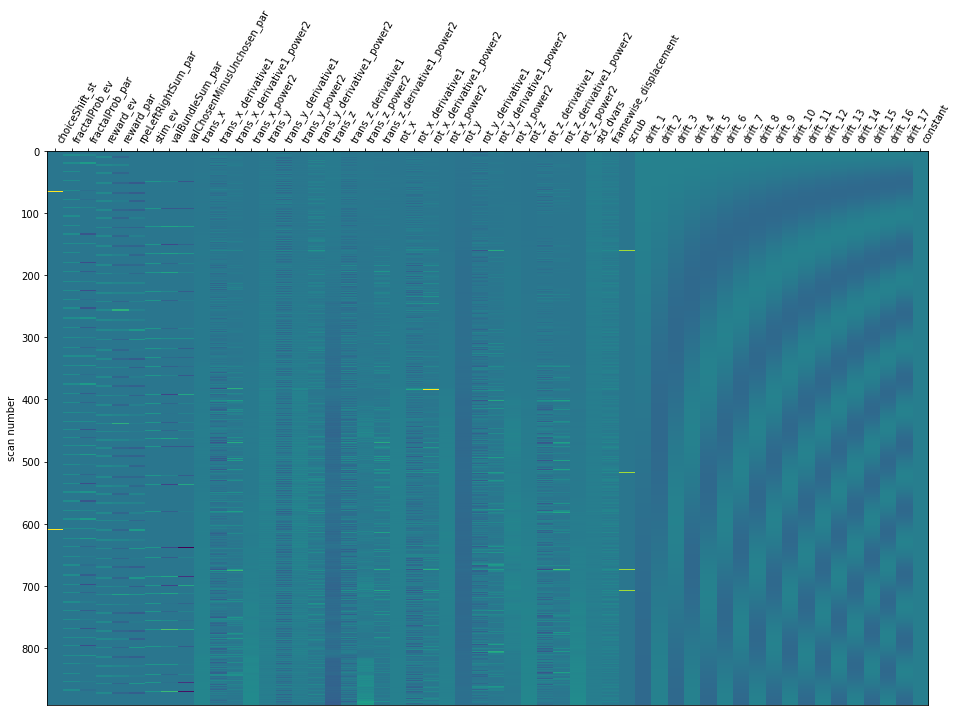

In [23]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model3', data_path, behavior_path, regress_rt = 0, hrf_model=None)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
plot_design_matrix(design_matrix)

A 'modulation' column was found in the given events data and is used.


<AxesSubplot:label='conditions', ylabel='scan number'>

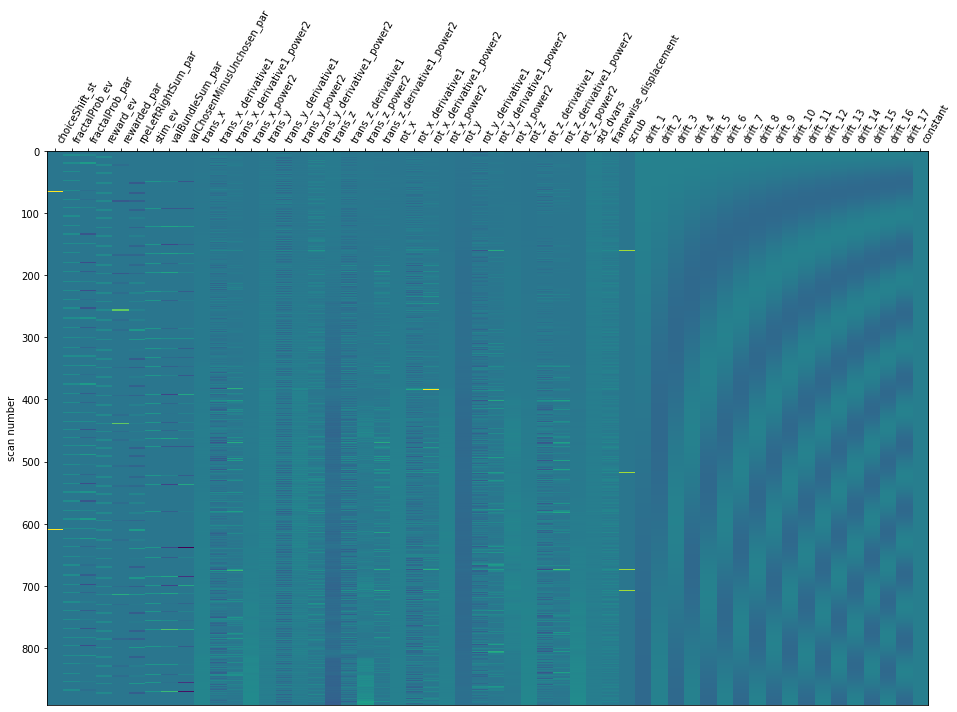

In [22]:
design_matrix2= make_level1_design_matrix(subnum, runnum, 'model4', data_path, behavior_path, regress_rt = 0, hrf_model=None)
beh_regs = design_matrix2.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix2[beh_regs].corr()
plot_design_matrix(design_matrix2)

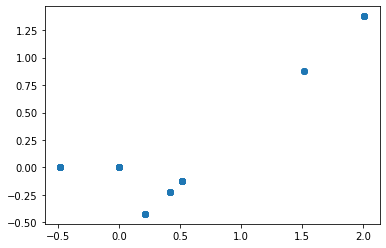

In [10]:
plt.scatter(design_matrix['reward_par'], design_matrix2['rewarded_par'])

Why is reward_par taking up so much variance?

Level2's for all subjects looks a lot more reasonable. There might be an error in level3 computation.

In [ ]:
l2_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level2/model3_reg-rt0'
imgs = glob.glob(os.path.join(l2_path, '*/*/*reward_par*'))

# for img in imgs:
#     plot_stat_map(img, threshold=3)